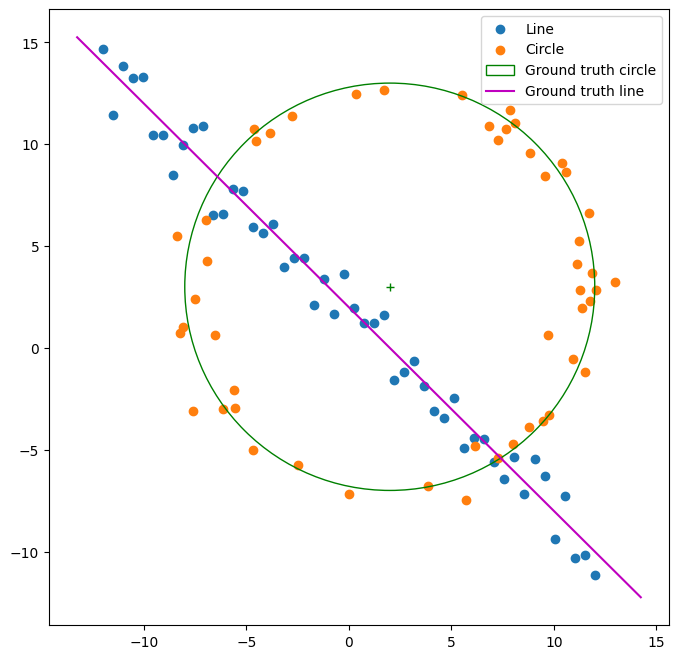

In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import math

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()



Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.922954774770742e-07
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.2465694463916346e-11
            Iterations: 14
            Function evaluations: 67
            Gradient evaluations: 14
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.8486225912270396e-11
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.202893596520906e-12
            Iterations: 8
            Function evaluations: 38
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.457670072829948e-07
            Iterations: 9
            Fu

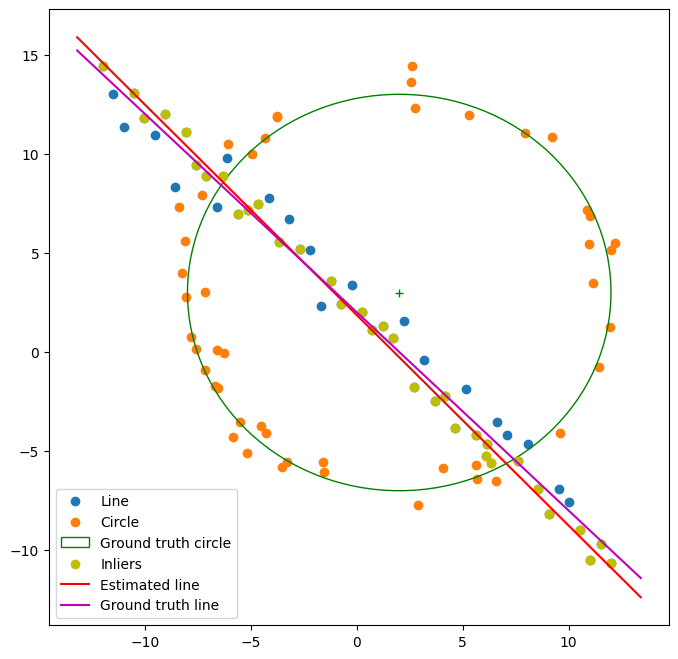

In [10]:
N=X.shape[0]
X_=X
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})
def consensus_line(X_, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

def ransac_line(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_line = []    
    res_only_with_sample = [] 
    best_inliers_line = []  
    for i in range(iter):
        indices = np.random.choice(n, 2, replace=False)
        x0 = [1, 1, 0]
        res = minimize(fun=line_tls, args=indices, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
        # Compute consensus
        inliers = consensus_line(X, res.x, t) 
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=line_tls, args=inliers, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_line = inliers
                best_a, best_b, best_d = res.x
                best_sample_line = indices
                print(indices)
                res_only_with_sample = x0

    return best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample

best_a, best_b, best_d, best_inliers_line, best_sample_line, res_only_with_sample = ransac_line(X, 0.63, 500, 0.32 * X.shape[0])

print(best_inliers_line.shape)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')
ax.scatter(X[best_inliers_line,0],X[best_inliers_line,1], color='y', label='Inliers')
#ax.scatter(best_sample_line[0],best_sample_line[1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a/best_b)*x_ + best_d/best_b
plt.plot(x_, y_est, color='r', label='Estimated line')
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


In [ ]:

remaining_points=X
if best_inliers_line is not None:
    remaining_points= remaining_points[best_inliers_line, :]

def circle_consensus(data, model,t):
    center_x, center_y, radius = model
    distances = np.sqrt((data[:, 0] - center_x)**2 + (data[:, 1] - center_y)**2)
    inliers = np.abs(distances - radius) < t
    return inliers

def circle_tls(x, indices, remaining_points):
    x_center, y_center, r = x[0], x[1], x[2]
    squared_errors = np.sqrt((remaining_points[indices, 0] - x_center)**2 + (remaining_points[indices, 1] - y_center)**2 )
    return np.sum(np.abs(squared_errors-r))
distance_treshold=0.4
con_c={'type': 'ineq', 'fun': lambda x: x[2] - distance_treshold}

def ransac_circle(X, t, iter, in_t):
    n = X.shape[0]
    best_error = np.inf
    best_sample_circle = []   
    res_only_with_sample = [] 
    best_inliers_circle = []  
    for i in range(iter):
        indices = np.random.choice(n, 3, replace=False)
        x0 = [1, 1, 1]
        res = minimize(fun=circle_tls, args=(indices,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': True})
        inliers = circle_consensus(X, res.x, t)
        n_inliers = np.sum(inliers)
        if n_inliers > in_t:
            x0 = res.x
            res = minimize(fun=circle_tls, args=(inliers,X), x0=x0, tol=1e-6, constraints=con_c, options={'disp': True})
            if res.fun < best_error:
                best_error = res.fun
                best_inliers_circle = inliers
                best_x_center, best_y_center, best_r = res.x
                best_sample_circle = indices
                print(indices)
                res_only_with_sample = x0

    return best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample

best_x_center, best_y_center, best_r, best_inliers_circle, best_sample_circle, res_only_with_sample = ransac_circle(remaining_points, distance_treshold, 1000, 0.7 * remaining_points.shape[0])

print(best_x_center, best_y_center, best_r)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for points
ax.scatter(X_line[:, 0], X_line[:, 1], color='b', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color='g', label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Inliers for line
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')

# Inliers for circle
#ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='Estimated circle')

ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')

# Estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
plt.plot(x_, y_est, color='r', label='Estimated line')

# Ground truth line
plt.plot(x_, y_, color='m', label='Ground truth line')

# Legend
plt.legend()
plt.show()


2.460203590028309 2.49840005790853 10.176519576385566


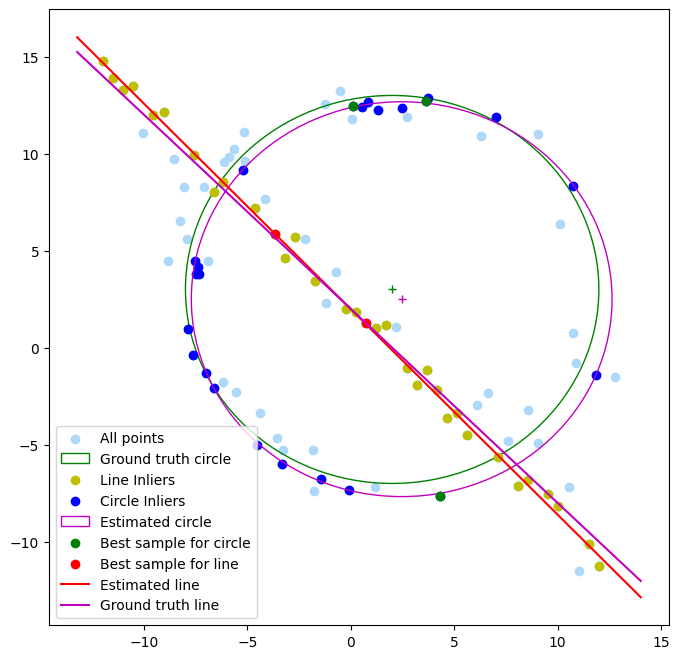

In [215]:
print(best_x_center, best_y_center, best_r)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
light_blue = (173/255, 216/255, 250/255)
# Scatter plot for points
ax.scatter(X[:, 0], X[:, 1], color=light_blue, label='All points')


# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

# Inliers for line
ax.scatter(X[best_inliers_line, 0], X[best_inliers_line, 1], color='y', label='Line Inliers')
ax.scatter(X_circ[best_inliers_circle, 0], X_circ[best_inliers_circle, 1], color='b', label='Circle Inliers')
# Inliers for circle
#ax.scatter(remaining_points[best_inliers_circle, 0], remaining_points[best_inliers_circle, 1], color='r', label='Circle Inliers')

# Estimated circle
circle_est = plt.Circle((best_x_center, best_y_center), best_r, color='m', fill=False, label='Estimated circle')

ax.add_patch(circle_est)
ax.plot(best_x_center, best_y_center, '+', color='m')
#plot best sample for circle in orange
ax.scatter(X_circ[best_sample_circle, 0], X_circ[best_sample_circle, 1], color='g', label='Best sample for circle')
#plot best sample for line in red
ax.scatter(X[best_sample_line, 0], X[best_sample_line, 1], color='r', label='Best sample for line')
# Estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
y_est = (-best_a / best_b) * x_ + best_d / best_b
plt.plot(x_, y_est, color='r', label='Estimated line')

# Ground truth line
plt.plot(x_, y_, color='m', label='Ground truth line')
# Legend
plt.legend()
plt.show()

In [196]:
print(remaining_points.shape)
print(best_inliers_circle.shape)
print(best_inliers_line)

(33, 2)
(50,)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False  True  True  True  True False  True  True False False  True
 False  True False False False  True False  True  True  True False  True
 False False  True  True  True  True  True False  True  True  True  True
  True  True  True False False  True False  True  True False  True  True
 False False  True  True]


In [11]:

import cv2 as cv
corner_points = []

def click_event(event, x, y, flags, param):
    global corner_points
    if event == cv.EVENT_LBUTTONDOWN:
        corner_points.append((x, y))
        cv.circle(background_image, (x, y), 5, (0, 0, 255), -1)  
        cv.imshow('Image',background_image)

        if len(corner_points) == 4:
            cv.destroyAllWindows()

img=cv.cvtColor(cv.imread('Building_new.png'), cv.COLOR_BGR2RGB)

background_image = cv.imread('Building_new.png')
cv.imshow('Image', background_image)
cv.setMouseCallback('Image', click_event)
cv.waitKey(0)
print("Selected Corner Points:")
for point in corner_points:
    print(point)






Selected Corner Points:
(34, 43)
(27, 117)
(107, 116)
(110, 56)


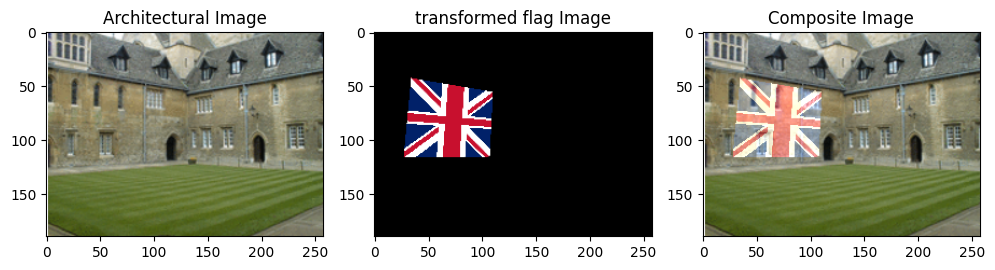

In [12]:

img1=cv.imread('Building_new.png')
flag_image = cv.imread('Flag_of_the_United_Kingdom_(1-2).svg.png')
pts_architecture = np.array(corner_points, dtype=np.float32)
pts_flag = np.array([[0, 0], [flag_image.shape[1], 0], [flag_image.shape[1], flag_image.shape[0]], [0, flag_image.shape[0]]], dtype=np.float32)
homography_matrix, _ = cv.findHomography(pts_flag, pts_architecture)
# Warp the flag image
flag_warped = cv.warpPerspective(flag_image, homography_matrix, (background_image.shape[1], background_image.shape[0]))
flag=cv.cvtColor(flag_warped, cv.COLOR_BGR2RGB)
alpha = 0.5 
composite_image = cv.addWeighted(img1, 1, flag_warped, alpha, 0, dst=background_image)
composite=cv.cvtColor(composite_image, cv.COLOR_BGR2RGB)
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Architectural Image')
plt.subplot(1, 3, 2)
plt.imshow(flag)
plt.title('transformed flag Image')
# Display the composite image
plt.subplot(1, 3, 3)
plt.imshow(composite)
plt.title('Composite Image')
plt.tight_layout()
plt.show()


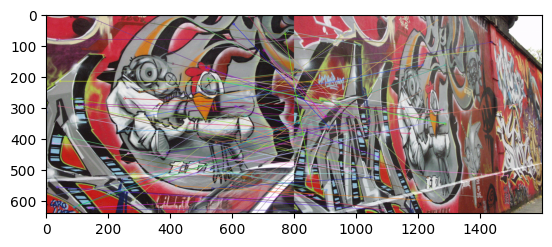

(<matplotlib.image.AxesImage at 0x21c1b811150>, None)

In [14]:
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des5, k=2)
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
img3 = cv.drawMatchesKnn(img1, kp1, img5, kp5, [good], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img3=cv.cvtColor(img3, cv.COLOR_BGR2RGB)
plt.imshow(img3), plt.show()





6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00

Computed Homography =  [[ 6.25835620e-01  7.58692654e-02  2.21292513e+02]
 [ 2.24080576e-01  1.17639865e+00 -2.51396544e+01]
 [ 4.95782910e-04 -1.08359489e-05  1.00000000e+00]]


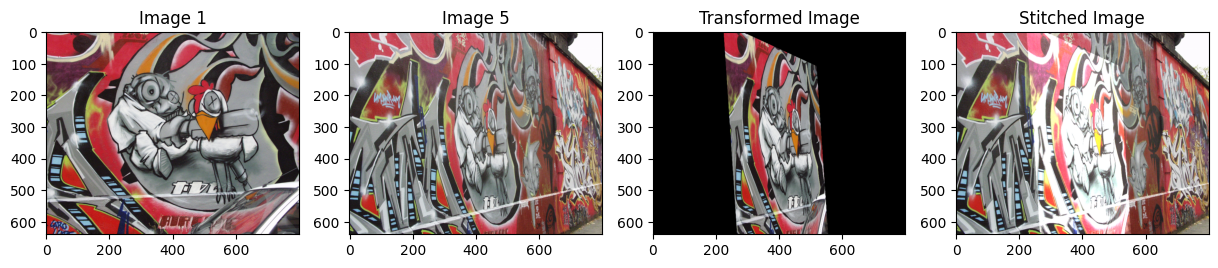

In [35]:
from random import randint
img2, img3, img4, img1, img5 = cv.imread("img2.ppm"), cv.imread("img3.ppm"), cv.imread("img4.ppm"), cv.imread("img1.ppm"), cv.imread("img5.ppm")
im1, im5, im2, im3, im4 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY), cv.cvtColor(img5, cv.COLOR_BGR2GRAY), cv.cvtColor(img2, cv.COLOR_BGR2GRAY), cv.cvtColor(img3, cv.COLOR_BGR2GRAY), cv.cvtColor(img4, cv.COLOR_BGR2GRAY)

ims = [im1, im2, im3, im4, im5]

def random_num(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))
    
    for i in range(len(l)):
        m[i] = np.sum(l==l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return random_num(n,t)

def Homography(p1, p2):
    x1, y1, x2, y2, x3, y3, x4, y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7] 
    x1T, x2T, x3T, x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T, -y1*x1T), axis = 1), np.concatenate((x1T, zero_matrix.T, -x1*x1T), axis = 1),
                            np.concatenate((zero_matrix.T,x2T, -y2*x2T), axis = 1), np.concatenate((x2T, zero_matrix.T, -x2*x2T), axis = 1),
                            np.concatenate((zero_matrix.T,x3T, -y3*x3T), axis = 1), np.concatenate((x3T, zero_matrix.T, -x3*x3T), axis = 1),
                            np.concatenate((zero_matrix.T,x4T, -y4*x4T), axis = 1), np.concatenate((x4T, zero_matrix.T, -x4*x4T), axis = 1)), axis = 0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temph= v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    return H

p, s, e= 0.999, 4, 0.5
N = int(np.ceil(np.log(1-p)/np.log(1-((1-e)**s))))
Ht = []
for i in range(4):
    sift = cv.SIFT_create()
    kp_1, des_1 = sift.detectAndCompute(ims[i],None)
    kp_2, des_2 = sift.detectAndCompute(ims[i+1],None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  
    matches = sorted(bf_match.match(des_1, des_2), key = lambda x:x.distance)
    Src_Points = [kp_1[k.queryIdx].pt for k in matches]
    Dest_Points = [kp_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(N):
        ran_points = random_num(len(Src_Points)-1, 4)
        f_points = []
        for j in range(4):
            f_points.append(np.array([[Src_Points[ran_points[j]][0], Src_Points[ran_points[j]][1], 1]]))
        t_points = []
        for j in range(4):
            t_points.append(Dest_Points[ran_points[j]][0]) 
            t_points.append(Dest_Points[ran_points[j]][1])

        H = Homography(f_points,t_points)
        inliers = 0 
        for k in range(len(Src_Points)):
            X = [Src_Points[k][0], Src_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0]-Dest_Points[k][0], 2) + np.power(HX[1]-Dest_Points[k][1], 2))
            if err < threshold:
                inliers +=1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H 
    Ht.append(best_H)
H1_H5 = Ht[3] @ Ht[2] @ Ht[1] @ Ht[0]
H1_H5 /= H1_H5[-1][-1]

print("Computed Homography = ", H1_H5)
transformed_im = cv.warpPerspective(img1, H1_H5, (np.shape(img5)[1], np.shape(img5)[0]))
final = cv.add(img5, transformed_im)

fig, ax = plt.subplots(1,4,figsize=(15,15))
ax[0].imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(transformed_im,cv.COLOR_BGR2RGB)), ax[2].set_title("Transformed Image")
ax[3].imshow(cv.cvtColor(final,cv.COLOR_BGR2RGB)), ax[3].set_title("Stitched Image")
plt.show()

   6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00

In [36]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image_gray = np.float32(gray)
h, w = image_gray.shape
# Define a range of sigma values to create the scale-space representation
sigma_values = np.arange(1, 33, 0.1)
scale_space = np.zeros((h, w, len(sigma_values)))
for i, sigma in enumerate(sigma_values):
    log_hw = 3 * sigma
    X, Y = np.meshgrid(np.arange(-log_hw, log_hw + 1), np.arange(-log_hw, log_hw + 1))
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)
    # Calculate the Laplacian of the Gaussian filter
    log = 1 / (2 * np.pi * sigma**2) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    f_log = cv.filter2D(image_gray, -1, log)
    scale_space[:, :, i] = np.absolute(f_log)



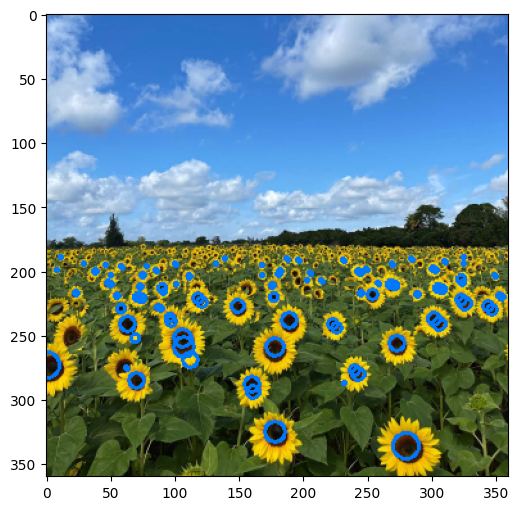

In [45]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
h, w, _ = image.shape
circle_mask = np.zeros((int(h),int(w)), dtype=np.uint8)
scale_threshold=77.5
for i in range(h):
    for j in range(w):
        max_scale = np.max(scale_space[i, j, :])
        if max_scale > scale_threshold and circle_mask[i, j] == 0:
            scale_idx = np.argmax(scale_space[i, j, :])
            sigma = sigma_values[scale_idx]
            s = int((2**0.5) * sigma)
            cv.circle(image, (j, i), s, (0, 120, 250), 2)
            cv.circle(circle_mask, (j, i), s, 1, -1)  
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.show()


In [11]:
indices = np.unravel_index(np.argmax(scale_space, axis=None), scale_space.shape)
print(np.max(scale_space)) # r = \sqrt{2}*sigma 
print(sigma_values[indices[2]])

102.1226577758789
2.5000000000000013
